# Pipelines, ML Wrap-Up
Los Pipelines son un tipo de objeto compuesto de Sklearn que facilitan mucho el trabajo repetitivo de procesado y entrenamiento. Se construyen como una secuencia de "transformadores" (modelos, preprocesadores, etc) que se aplican uno detrás de otro y a los que se pueden añadir selección por columnas y funciones diseñadas por el usuario.

In [1]:
# Primero el pipeline más sencillo imputer y scaler comparado con ir haciendo una función que lo hace todo
# Selección por columnas
# Funciones personalizadas
# Meter un modelo
# Usar el grid_search

In [2]:
def data_report(df):
    '''Esta funcion describe los campos de un dataframe de pandas de forma bastante clara, crack'''
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

## Datos de Partida  
Sí, my heart will go on

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score


In [ ]:
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


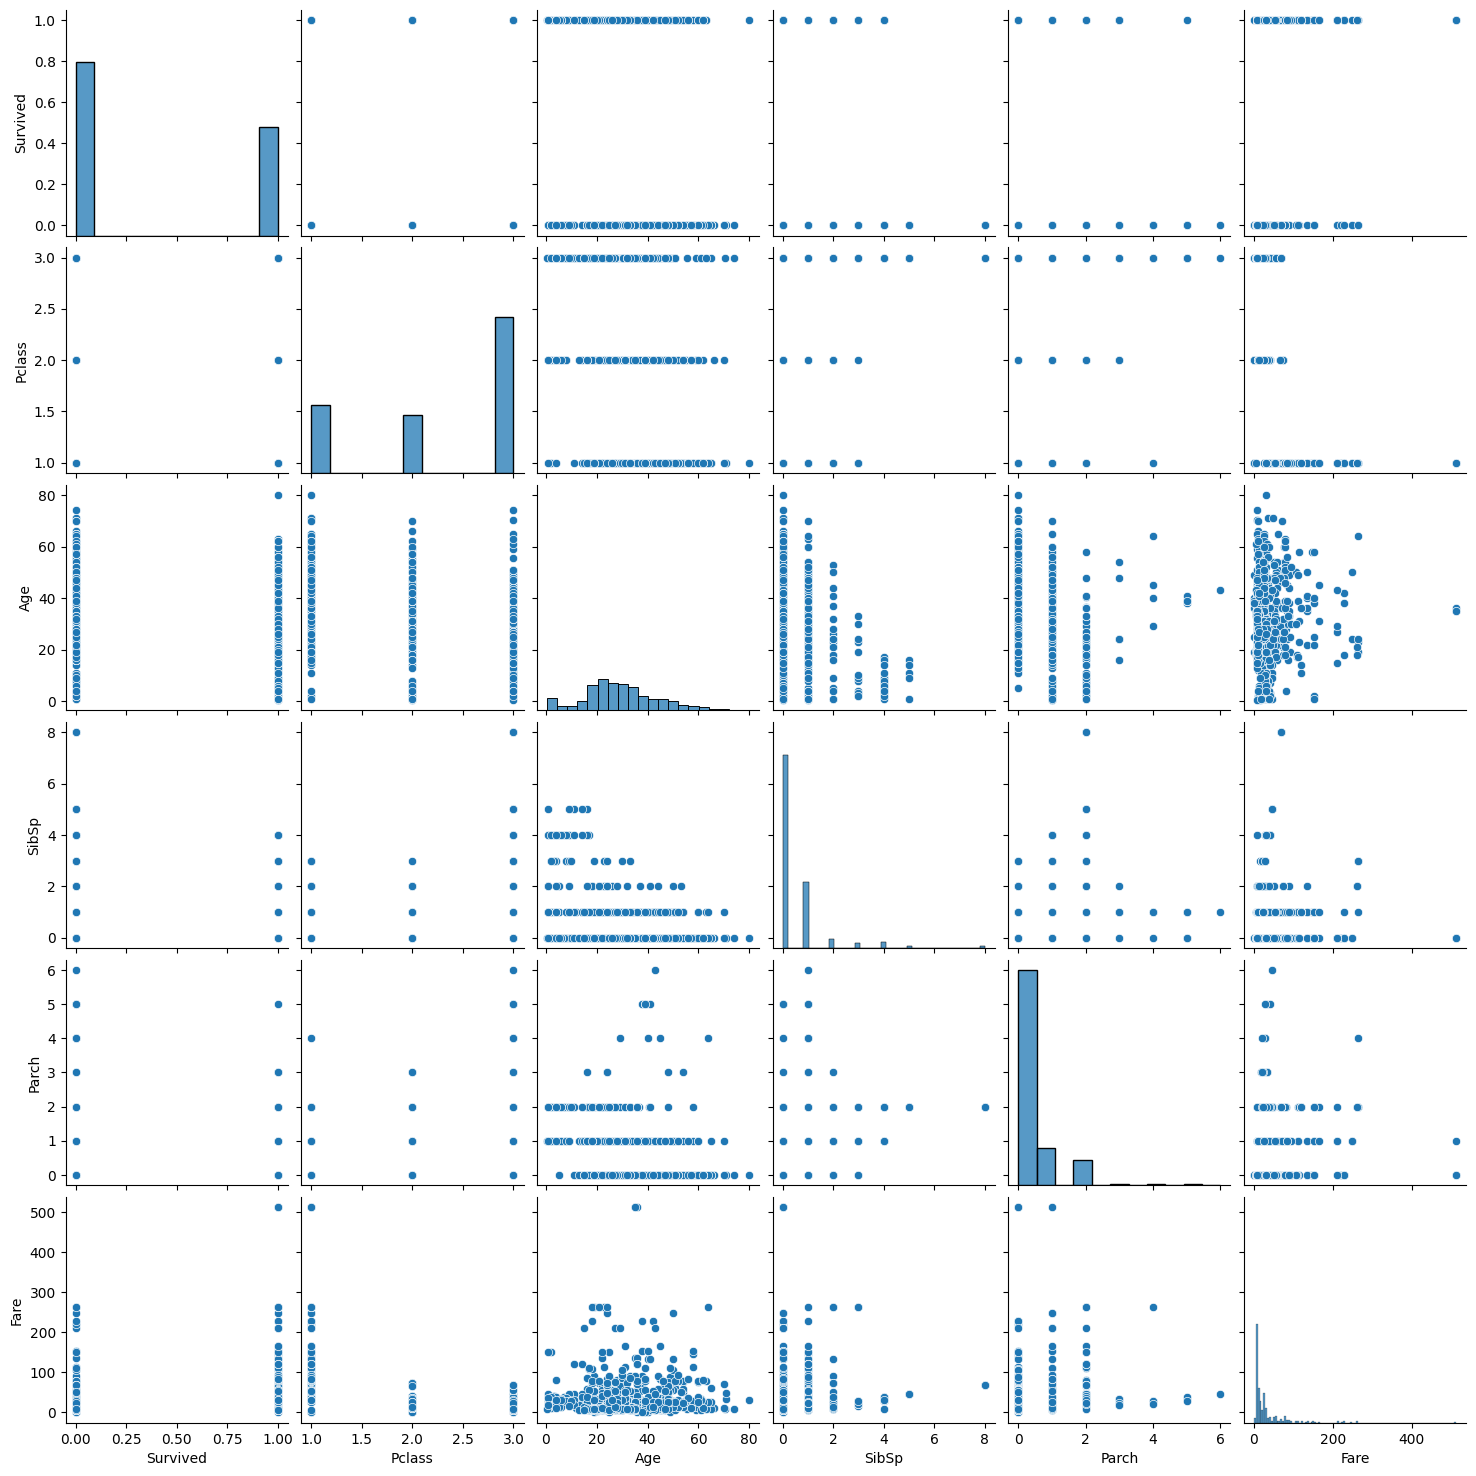

In [7]:
sns.pairplot(train.drop(["Name","PassengerId"],axis = 1))

In [8]:
data_report(train)

COL_N,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
DATA_TYPE,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,19.87,0.0,0.0,0.0,0.0,77.1,0.22
UNIQUE_VALUES,891,2,3,891,2,88,7,7,681,248,147,3
CARDIN (%),100.0,0.22,0.34,100.0,0.22,9.88,0.79,0.79,76.43,27.83,16.5,0.34


## LIMPIEZA INICIAL  
(Aquí todavía no pienso en Pipelines, ni en splits)

Nos apuntamos las columnas que son identificadores unicos para descartarlos posteriormente

In [9]:
columns_to_exclude = ["PassengerId","Name"]

Tenemos que tomar una decisión respecto a cuatro features, debido a su nivel de "nulos", o su cardinaliad siendo "textual"/"categórica": __Age, Cabin, Ticket, Embarked.__
__Fare__ podría ser discutible por su cardinalidad (27.83) pero es numérica, sin missings, nos las quedamos.

### Age

Esta suficientemente informada?

In [10]:
print(len(train[train.Age.isna() == False])/len(train))

0.8013468013468014


Un 80% tiene buena pinta si la variables es continua o categorica como para hacer una imputación.
Como es continua pero entera (no hay decimales) podemos imputarle la media redondeada, convertirla a categorica con tramos iguales (binning) y escoger la moda de esos binnings.   
Para este ejeplo le imputaremos la media.
Pero no lo hacemos ya, esperamos a tener toda la estrategia de imputación/drop clara... O hazlo ya impaciente, si eres de los que le gusta ir para arriba y para abajo :-)

### Embarked

Esta casi completamente informada, así que la quiero conservar.  
Tenemos que decidir qué hacemos con los dos valores faltantes:
- Puedo hacer una imputación a la categoría más frecuente
- Puedo "prescindir" de las filas en las que falta esta feature (ojo tendré que hacerlo luego posteriormente con cada instancia que me viniera sin este dato, por eso no suele ser aconsejable este método si queremos dar una "etiqueta"/Prediccion/f(x) para todas las instancias que nos lleguen en el futuro)
- Puedo prescindir de la columna

Faltando tan pocos valores lo más práctico es imputar, pero si fueran valores más altos (más de un 20%, pero la experiencia ya os dirá el número para el campo de dominio que trabajéis), es bueno ver si es fácil imputar y si es informativa la feature

In [11]:
train.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Solo tres clases, imputariamos además S a los valores faltantes (la más frecuente)

¿Es informativa? Lo mejor es hacer un test estadístico contra el target o calcular su information value. Ahora lo vamos a hacer a "ojimetro"

In [12]:
train[train.Embarked == "S"].Survived.value_counts(True)

Survived
0    0.663043
1    0.336957
Name: proportion, dtype: float64

In [13]:
train[train.Embarked == "C"].Survived.value_counts(True)

Survived
1    0.553571
0    0.446429
Name: proportion, dtype: float64

In [14]:
train[train.Embarked == "Q"].Survived.value_counts(True)

Survived
0    0.61039
1    0.38961
Name: proportion, dtype: float64

In [15]:
train.Survived.value_counts(True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Ser S o Q no parece diferenciarse mucho del conjunto total, pero haber embarcado en C, sí que cambia algo la distribución. Así que me la quedo e imputo la de mayor frecuencia

### Cabin

En Cabin tenemos el problema de que faltan muchos valores, tenemos un 23% escaso de instancias informadas

In [16]:
print(len(train[train.Cabin.isna() == False])/len(train))

0.22895622895622897


Las features a imputar tienen que tener valor informativo (correlar con el target) y además un método "sencillo" para poder hacer esa imputación

Antes de comprobar el valor informativo, veamos la cardinaliad (valores diferentes que tiene sobre el total) en el caso de categóricas o la varianza/distribución en el caso de numéricas

Cabin es categórca/textual, veamos cuantos registros diferentes en relación con el total de informados

In [17]:
print(len(train.Cabin.unique())/len(train[train.Cabin.isna() == False]))


0.7254901960784313


El 72% de los valores informados son únicos, lo que es normal porque son camarotes, hacer una imputación es practicamente imposible, así que prescindiremos de la columna, la eliminamos

In [ ]:
columns_to_exclude.append("Cabin") #Añadimos cabin a la lista
print(columns_to_exclude) # Estas son las 3 columnas que tengo para eliminar

['PassengerId', 'Name', 'Cabin']


### Ticket

Mucha cardinalidad (76%) y texto (object), veamos que pinta tiene

In [ ]:
train.Ticket.value_counts(True)
# Son números muy bajos, es imposible determinar los que faltan

Ticket
347082      0.007856
CA. 2343    0.007856
1601        0.007856
3101295     0.006734
CA 2144     0.006734
              ...   
9234        0.001122
19988       0.001122
2693        0.001122
PC 17612    0.001122
370376      0.001122
Name: proportion, Length: 681, dtype: float64

De primeras, fuera. Si tuviera que rascar a lo mejor intentaríamos buscar alguna "codificación" de cada Ticket (por ejemplo relacionandolo con Fare, se ve que los hay letraletra numero y solo número), pero eso si necesito rascar más

In [20]:
columns_to_exclude.append("Ticket")
print(columns_to_exclude)

['PassengerId', 'Name', 'Cabin', 'Ticket']


### Levad anclas, soltad amarres,...

## Func vs Pipeline

A partir de aquí vamos a hacer dos hilos de preprocesado, uno con funciones y otro con Pipeline que harán lo mismo

## Exclusión de columnas

In [ ]:
# FUNCTION_BASED_PREPROCESSING

# Función que elimina las columnas
def func_exclude_columns(X, exclude_cols = columns_to_exclude):
    # Skip missing values from colum
    X_temp = X[[col for col in X.columns if col not in exclude_cols]].copy()
    return X_temp
    

In [40]:
# PIPELINE PREPROCESSING

Un pipeline es una lista de objetos (llamados "transformers" en terminología Sklearn, no confundir con los transformes de Deep) que se van a ejecutar en orden cada vez que llamemos a su método fit o fit_transform o predict. Por ejemplo, si hemos creado un objeto Pipeline con nombre PipeExample, luego podremos ejecutar PipeExample.fit -> (que llama a los métodos fit_transform de todos los elementos de PipeExample, salvo del último que sólo ejecuta fit) o PipeExample.predict -> (Que llama a los métodos transform de todos los elementos de PipeExample, salvo del último que sólo ejecutara predict) o PipeExample.fit_transform (Que llamará a todos los fit_transform de todos los elementos). Evidentemente el último elemento de PipeExample tiene que tener un método predict o un método fit o un método fit_transform para poder ejecutar los comandos anteriores.

PipeExample = Pipeline(["a",(Transformer_A()),("b",(Transformer_B()),("c",(Transformer_C())])

* PipeExample.fit(X<,y>) equivale a Transformer_C.fit(Transformer_B.fit_transform(Transformer_A.fit_transform(X<,y>)<,y>)<,y>)  
* PipeExample.predict(X) equivale a Transformer_C.predict(Transformer_B.transform(Transformer_A.transform(X)))  
* PipeExample.fit_transform(X,y) equivale a Transformer_C.fit_transform(Transformer_B.fit_transform(Transformer_A.fit_transform(X<,y>)<,y>),y)

Como un Pipeline es un transformer :-) se puede meter como paso dentro de otro Pipeline (lo cual para entenderlo lo complica, pero le da mucha versatilidad) (OJO si ese pipeline termina con un "modelo" que no tiene fit_transform, tiene que ser el último elemento del nuevo pipeline o dará error)

Supongamos que Transformer_C es un modelo ( ejemplo Transformer_C es RandomForestClassifier):
* PipePipeExample = Pipeline([("mal_ejemplo",PipeExample()), ("da_igual", OtroPipe())]) -> Dará error
* PiPeGoodExample = Pipeline([ ("el_primero", OtroPipe()),("bien",PipeExample())]) -> Si OtroPipe no es un modelo o tiene fit_transform, todo OK :-)


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline # El make_pipeline le digo directamente lo que quiero, es más facil de llevar 
# pero el Pepeline tiene más rango para que lo utilices con funciones y tal
from sklearn.compose import ColumnTransformer

In [24]:
# Column Transformer nos permite aplicar diferentes transformers según las columnas
pipe_exclude_columns = ColumnTransformer([("excluye","drop", columns_to_exclude)], remainder = "passthrough")

In [25]:
# Probemos que los dos dan "el mismo resultado"

In [ ]:
pipe_exclude_columns.get_params() # estos para metros son internos pero así vemos lo que hace

{'force_int_remainder_cols': True,
 'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('excluye',
   'drop',
   ['PassengerId', 'Name', 'Cabin', 'Ticket'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'excluye': 'drop'}

In [27]:
train_compacto = func_exclude_columns(train, columns_to_exclude)

In [47]:
train_compacto

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [28]:
pipe_train_compacto = pipe_exclude_columns.fit_transform(train)

In [29]:
df_check = pd.DataFrame(pipe_train_compacto, columns = pipe_exclude_columns.get_feature_names_out())

In [ ]:
df_check #El remainder lo pone automaticamente pero se lo podemos quitar

,remainder__Survived,remainder__Pclass,remainder__Sex,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare,remainder__Embarked
0,0,3,male,22.0,1,0,7.25,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.925,S
3,1,1,female,35.0,1,0,53.1,S
4,0,3,male,35.0,0,0,8.05,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0,S
887,1,1,female,19.0,0,0,30.0,S
888,0,3,female,NaN,1,2,23.45,S
889,1,1,male,26.0,0,0,30.0,C


Primera ventaja para las funciones, devuelven el dataframe, segunda ventaja, el paso de parámetros es más flexible

## Imputamos valores faltantes

In [31]:
age_mean = train_compacto.Age.mean()

In [32]:
train_compacto.Embarked.mode()

0    S
Name: Embarked, dtype: object

In [33]:
train_compacto.Embarked.value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [34]:
age_mean

29.69911764705882

In [35]:
# FUNCTION BASED PROCESSING
def func_missing_imputer(X, mean_col_imputed = [], mode_col_imputed = []):
    X_temp = X.copy()
    for col in mean_col_imputed:
        valor_imputado = round(X_temp[col].mean(),0)
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    for col in mode_col_imputed:
        valor_imputado = X_temp[col].mode().values[0]
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    return X_temp
        

In [ ]:
# PIPELINE PROCESSING
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector

# Vamos a hacer un pequeño truco :-), que luego repetiremos porque después del primer paso ya no podemos utilizar las columnas de pandas
imputer_step = ColumnTransformer(
    [("Impute_Numeric", SimpleImputer(), ["Age"]), # Le pongo nombre ("Impute_numeric"), le digo como quiero imputarlo (SimpleImputer)y a que lo imputo
     ("Impute_Mode", SimpleImputer(strategy = "most_frequent"), ["Embarked"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")

pipe_missings = Pipeline([("first_stage",imputer_step)])

In [37]:
train_almost_ready = func_missing_imputer(train_compacto, mean_col_imputed= ["Age"], mode_col_imputed= ["Embarked"])

In [38]:
pipe_train = pipe_missings.fit_transform(train)

In [39]:
train_almost_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [40]:
df_check = pd.DataFrame(pipe_train, columns = pipe_missings.get_feature_names_out())

In [41]:
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Impute_Numeric__Age    891 non-null    object
 1   Impute_Mode__Embarked  891 non-null    object
 2   remainder__Survived    891 non-null    object
 3   remainder__Pclass      891 non-null    object
 4   remainder__Sex         891 non-null    object
 5   remainder__SibSp       891 non-null    object
 6   remainder__Parch       891 non-null    object
 7   remainder__Fare        891 non-null    object
dtypes: object(8)
memory usage: 55.8+ KB


## Codificación de Variables Categóricas (OneHotEnconder vs OrdinalEncoder)

El LabelEncoder se recomienda solo para la target

Tenemos dos features a codificar: __Sex__ y __Embarked__  
Ambas tienen pocos valores, por lo que podemos usar un OneHotEncoder, si tuvieran muchos valores de etiquetas podríamos hacer un OneHotEncoder y una PCA sobre estos, o agrupar las categorías en función de su correlación con el target, o buscar algún mecanismo de agrupación no supervisado que las agrupe por semejanza

In [42]:
# Encoding with functions
from sklearn.preprocessing import OneHotEncoder

def func_oneHotEnconder(X, cols_to_encode):
    X_temp = X.copy()
    OHEncoder = OneHotEncoder()
    OHEncoder.fit(X_temp[cols_to_encode])
    X_temp = pd.concat([X_temp, pd.DataFrame(OHEncoder.transform(X_temp[cols_to_encode]).toarray(),
                                            columns = OHEncoder.get_feature_names_out())], axis = 1)
    return X_temp.drop(cols_to_encode, axis = 1)

In [ ]:
# Encoding with pipeline

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder())
    ]
)

preprocessing = ColumnTransformer(
    [("Impute_Numeric", SimpleImputer(), ["Age"]), # Numéricas
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked"]), # Categóricas
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")



In [44]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric', SimpleImputer(), ['Age']),
                                ('Process_Categorical',
                                 Pipeline(steps=[('Impute_Mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHEncoder',
                                                  OneHotEncoder())]),
                                 ['Sex', 'Embarked']),
                                ('Exclude', 'drop',
                                 ['PassengerId', 'Name', 'Cabin', 'Ticket'])])

In [45]:
train_almost_ready_encoded = func_oneHotEnconder(train_almost_ready, ["Sex","Embarked"])

In [46]:
pipe_preprocessed = preprocessing.fit_transform(train)

In [47]:
df_check = pd.DataFrame(pipe_preprocessed, columns= preprocessing.get_feature_names_out())

In [48]:
train_almost_ready_encoded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [49]:
df_check.head()

,Impute_Numeric__Age,Process_Categorical__Sex_female,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,remainder__Survived,remainder__Pclass,remainder__SibSp,remainder__Parch,remainder__Fare
0,22.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,7.2500
1,38.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,71.2833
2,26.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,7.9250
3,35.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,53.1000
4,35.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,8.0500


In [50]:
train_almost_ready_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    float64
 7   Sex_male    891 non-null    float64
 8   Embarked_C  891 non-null    float64
 9   Embarked_Q  891 non-null    float64
 10  Embarked_S  891 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 76.7 KB


In [51]:
train.Parch.value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

La distribución de __Fare__ tiene una forma de larga cola que puede beneficiarse de una transformación logarítmica

In [52]:
train[train.Fare <1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [53]:
train.Fare.apply(np.log).min()

-inf

In [54]:
train['Fare'] = train['Fare'] + 1

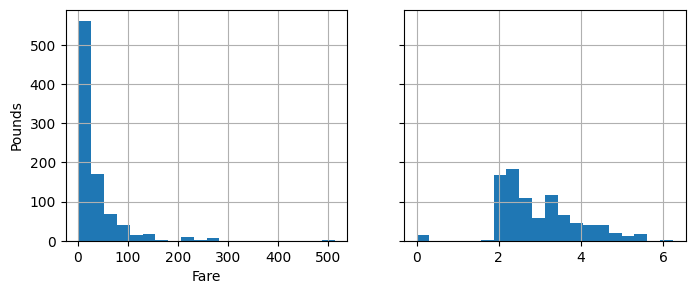

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
train["Fare"].hist(ax=axs[0], bins=20)
train["Fare"].apply(np.log).hist(ax=axs[1], bins=20) # Con el log me da una distribución más normal
axs[0].set_xlabel("Fare")
#axs[1].set_xlabel("Log of Fare")
axs[0].set_ylabel("Pounds")

plt.show()

## Escalado

Dado que utilizaremos un LogisticRegressor, entre otros, vamos a escalar  
Pero sólo con las verdaderas variables numéricas (PClass, SibSp y Parch son realmente ordinales, las dejamos tal cual)
Si queremos rascar más podemos escalarlas posteriormente y volver a probar.

In [58]:
# Encoding with functions
from sklearn.preprocessing import StandardScaler

# Estandarizamos los datos
def func_StandardScaler(X, cols_to_scale):
    X_temp = X.copy()
    SScaler = StandardScaler()
    SScaler.fit(X_temp[cols_to_scale])
    X_temp[cols_to_scale] = SScaler.transform(X_temp[cols_to_scale])
    return X_temp

In [59]:
numeric_cols = ["Age","Fare"]

In [60]:
train_processed = func_StandardScaler(train_almost_ready_encoded, numeric_cols)

In [61]:
train_processed

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,-0.597055,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0
1,1,1,0.634162,1,0,0.786845,1.0,0.0,1.0,0.0,0.0
2,1,3,-0.289251,0,0,-0.488854,1.0,0.0,0.0,0.0,1.0
3,1,1,0.403309,1,0,0.420730,1.0,0.0,0.0,0.0,1.0
4,0,3,0.403309,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,-0.212299,0,0,-0.386671,0.0,1.0,0.0,0.0,1.0
887,1,1,-0.827908,0,0,-0.044381,1.0,0.0,0.0,0.0,1.0
888,0,3,0.018554,1,2,-0.176263,1.0,0.0,0.0,0.0,1.0
889,1,1,-0.289251,0,0,-0.044381,0.0,1.0,1.0,0.0,0.0


In [ ]:
# Categoricas
cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder())
    ]
)

# Numéricas
num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")),
     ("SScaler", StandardScaler())
    ]
)

preprocessing = ColumnTransformer(
    [("Impute_Numeric", num_pipeline, ["Age","Fare"]),
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")

In [63]:
pipe_preprocessed = preprocessing.fit_transform(train)

In [64]:
df_check = pd.DataFrame(pipe_preprocessed, columns= preprocessing.get_feature_names_out())

## Agrupamos funciones para el procesado e incluimos Survived en las excluidas (lo deberíamos haber hecho al principio)

In [ ]:
# Preprocesado en una única función, todo junto

def func_exclude_columns(X, exclude_cols = columns_to_exclude):
    # Skip missing values from colum
    X_temp = X[[col for col in X.columns if col not in exclude_cols]].copy()
    return X_temp
    
def func_missing_imputer(X, mean_col_imputed = [], mode_col_imputed = []):
    X_temp = X.copy()
    for col in mean_col_imputed:
        valor_imputado = round(X_temp[col].mean(),0)
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    for col in mode_col_imputed:
        valor_imputado = X_temp[col].mode().values[0]
        es_nulo = X_temp[col].isna()
        X_temp.loc[es_nulo,col] = valor_imputado
    return X_temp
            

def func_oneHotEnconder(X, cols_to_encode):
    X_temp = X.copy()
    OHEncoder = OneHotEncoder()
    OHEncoder.fit(X_temp[cols_to_encode])
    X_temp = pd.concat([X_temp, pd.DataFrame(OHEncoder.transform(X_temp[cols_to_encode]).toarray(),
                                            columns = OHEncoder.get_feature_names_out())], axis = 1)
    return X_temp.drop(cols_to_encode, axis = 1)
    
def func_StandardScaler(X, cols_to_scale):
    X_temp = X.copy()
    SScaler = StandardScaler()
    SScaler.fit(X_temp[cols_to_scale])
    X_temp[cols_to_scale] = SScaler.transform(X_temp[cols_to_scale])
    return X_temp

columns_to_exclude.append("Survived")

# Dentro de una función metemos las otras funciones
def preprocess_data(X, columns_to_exclude = columns_to_exclude, 
                    mean_col_imputed = ["Age"], 
                    mode_col_imputed = ["Embarked"], 
                    cols_to_encode = ["Sex","Embarked","Pclass"], 
                    cols_to_scale = ["Age","Fare"]):
    X_temp = func_exclude_columns(X, columns_to_exclude)
    X_temp = func_missing_imputer(X_temp, mean_col_imputed, mode_col_imputed)
    X_temp = func_oneHotEnconder(X_temp, cols_to_encode)
    X_temp = func_StandardScaler(X_temp, cols_to_scale)
    return X_temp
    

Todo este lio de funciones  de arriba se puede cambiar por este codigo de abajo:

In [66]:
# Modo Pipeline

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder())
    ]
)

num_pipeline = Pipeline(
    [("Impute_Mean", SimpleImputer(strategy = "mean")),
     ("SScaler", StandardScaler())
    ]
)

preprocessing = ColumnTransformer(
    [("Impute_Numeric", num_pipeline, ["Age","Fare"]),
     ("Process_Categorical", cat_pipeline, ["Sex","Embarked","Pclass"]),
     ("Exclude", "drop", columns_to_exclude)
    ], remainder = "passthrough")


In [67]:
func_train = preprocess_data(train)

In [68]:
pipe_train = preprocessing.fit_transform(train)

In [69]:
df_pipe_train = pd.DataFrame(pipe_train, columns = preprocessing.get_feature_names_out())

In [70]:
func_train.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,-0.597055,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.634162,1,0,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-0.289251,0,0,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.403309,1,0,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.403309,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [71]:
df_pipe_train.head()

,Impute_Numeric__Age,Impute_Numeric__Fare,Process_Categorical__Sex_female,Process_Categorical__Sex_male,Process_Categorical__Embarked_C,Process_Categorical__Embarked_Q,Process_Categorical__Embarked_S,Process_Categorical__Pclass_1,Process_Categorical__Pclass_2,Process_Categorical__Pclass_3,remainder__SibSp,remainder__Parch
0,-0.592481,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.638789,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.284663,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.407926,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,0.407926,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [72]:
y_train = train.Survived

## A MODELAR

Seguiremos comparando el sistema con funciones vs. el sistema con Pipes

Vamos a comparar __LogistRegression__, __RandomForest__ y __XGBoost__

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import re


In [75]:
# Usando funciones


model_list = [LogisticRegression, RandomForestClassifier, XGBClassifier]

def model(model_list,X = None,y = None, cv = 5, scoring = "accuracy"):
    resultados = {}
    X_train = preprocess_data(X)
    for model in model_list:
        model_name = re.match("<class '(.*?)'>",str(model)).group(1).split(".")[-1]
        resultados[model_name] = cross_val_score(model(), X_train,y, cv = cv, scoring = scoring)
        print("<%s>: %.4f" %(model_name,np.mean(resultados[model_name])))
    return resultados

In [76]:
model(model_list,train,y_train)

<LogisticRegression>: 0.7935
<RandomForestClassifier>: 0.8115
<XGBClassifier>: 0.8149


{'LogisticRegression': array([0.77653631, 0.79775281, 0.78651685, 0.76966292, 0.83707865]),
 'RandomForestClassifier': array([0.7877095 , 0.78651685, 0.88202247, 0.76966292, 0.83146067]),
 'XGBClassifier': array([0.78212291, 0.82022472, 0.84269663, 0.79213483, 0.83707865])}

In [77]:
# Usando Pipes

logistic_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", LogisticRegression())
    ])

random_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", RandomForestClassifier())
    ])

xgb_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", XGBClassifier())
    ])

for name,pipe in zip(["logistic","randomF", "XGB"],[logistic_pipeline, random_pipeline, xgb_pipeline]):
    resultado = cross_val_score(pipe, train, y_train, cv = 5, scoring = "accuracy")
    print(f"{name}: {np.mean(resultado):.4f}")
    print(resultado)
    

logistic: 0.7946
[0.77653631 0.80337079 0.78651685 0.76966292 0.83707865]
randomF: 0.8059
[0.79329609 0.79775281 0.83707865 0.78089888 0.82022472]
XGB: 0.8104
[0.7877095  0.80337079 0.84269663 0.78089888 0.83707865]


Los valores en CV son similares, así que vamos a comparar después de ajustar los hiperparámetros

In [79]:
from sklearn.model_selection import GridSearchCV

# Definimos sus hiperparametros
reg_log_param = {    
                 "penalty": [None,"l2"], 
                 "C": np.logspace(0, 4, 10)
                }

rand_forest_param = {
    'n_estimators': [10, 100, 200, 400],
    'max_depth': [1,2,4,8],
    'max_features': [1, 2, 3]
    }

xgb_param = {
    'n_estimators': [10, 100, 200, 400],
    'max_depth': [1,2,4,8],
    'learning_rate': [0.1,0.2,0.5,1.0]
}

cv = 5

gs_reg_log = GridSearchCV(LogisticRegression(),
                            reg_log_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(RandomForestClassifier(),
                            rand_forest_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_xgb = GridSearchCV(XGBClassifier(),
                        xgb_param,
                        cv=cv,
                        scoring="accuracy",
                        verbose=1,
                        n_jobs=-1)

grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb}
    



In [80]:
%%time
X_train = preprocess_data(train)
for nombre, grid_search in grids.items():
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 2.67 s
Wall time: 21.4 s


In [81]:
best_grids = [(i, j.best_score_) for i, j in grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
2,gs_xgb,0.841755
1,gs_rand_forest,0.833915
0,gs_reg_log,0.793510


In [82]:
pipe_reg_log_param = {    
                 "Modelo__penalty": [None,"l2"], 
                 "Modelo__C": np.logspace(0, 4, 10)
                }

pipe_rand_forest_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [1,2,4,8],
    'Modelo__max_features': [1, 2, 3]
    }

pipe_xgb_param = {
    'Modelo__n_estimators': [10, 100, 200, 400],
    'Modelo__max_depth': [1,2,4,8],
    'Modelo__learning_rate': [0.1,0.2,0.5,1.0]
}

cv = 5

gs_reg_log = GridSearchCV(logistic_pipeline,
                            pipe_reg_log_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_rand_forest = GridSearchCV(random_pipeline,
                            pipe_rand_forest_param,
                            cv=cv,
                            scoring="accuracy",
                            verbose=1,
                            n_jobs=-1)

gs_xgb = GridSearchCV(xgb_pipeline,
                        pipe_xgb_param,
                        cv=cv,
                        scoring="accuracy",
                        verbose=1,
                        n_jobs=-1)

pipe_grids = {"gs_reg_log":gs_reg_log,
         "gs_rand_forest":gs_rand_forest,
         "gs_xgb":gs_xgb}
    



In [83]:
%%time
for nombre, grid_search in pipe_grids.items():
    grid_search.fit(train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 4.28 s
Wall time: 17.6 s


In [84]:
best_grids = [(i, j.best_score_) for i, j in pipe_grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
2,gs_xgb,0.841755
1,gs_rand_forest,0.831680
0,gs_reg_log,0.794633


In [85]:
y_test = test.Survived

In [86]:
from sklearn.metrics import classification_report

In [87]:
print(classification_report(y_test, grids["gs_xgb"].best_estimator_.predict(preprocess_data(test))))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       260
           1       0.76      0.63      0.69       158

    accuracy                           0.78       418
   macro avg       0.78      0.75      0.76       418
weighted avg       0.78      0.78      0.78       418



In [88]:
print(classification_report(y_test, pipe_grids["gs_rand_forest"].best_estimator_.predict(test)))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       260
           1       0.73      0.65      0.69       158

    accuracy                           0.78       418
   macro avg       0.77      0.75      0.76       418
weighted avg       0.77      0.78      0.77       418



In [89]:
print(classification_report(y_test, pipe_grids["gs_rand_forest"].best_estimator_.predict(test)))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       260
           1       0.73      0.65      0.69       158

    accuracy                           0.78       418
   macro avg       0.77      0.75      0.76       418
weighted avg       0.77      0.78      0.77       418



###### 